In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
import keras
%matplotlib inline

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/UGP23/dataset/Yoga_82_modified/yoga_82/train_keypoints_yoga82.csv")

In [ ]:
train.labels.value_counts()

6    274
4    240
8    189
3    162
5    158
7    135
2    123
1    111
0    110
Name: labels, dtype: int64

In [ ]:
x_train = train.drop(['file_name', 'labels'], axis=1)
y_train = train.labels

In [ ]:
!pip install -q mediapipe

In [ ]:
import mediapipe as mp

mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

def norm(x_train):
    # Create an empty dataframe to store the normalized landmarks
    landmarks_norm=[]
    # Loop through all the samples in x_train
    for i in range(x_train.shape[0]):
        # Extract the landmark points for the current sample
        landmarks = x_train.iloc[i]
        landmarks = landmarks.values.reshape(-1, 3)  # Extract only the x, y and z coordinates

        # Step 1: Calculate the pose center
        left_hip = landmarks[mp_pose.PoseLandmark.LEFT_HIP.value] # index corresponds to the left hip landmark
        right_hip = landmarks[mp_pose.PoseLandmark.RIGHT_HIP.value] # index corresponds to the right hip landmark
        pose_center = 0.5*(left_hip+right_hip)

        # Step 2: Get relative position
        landmarks_rel_pos = np.array([[lm[0] - pose_center[0], lm[1] - pose_center[1], lm[2]] for lm in landmarks])

        # Step 3: Normalize by distance
        landmarks_norm.append(np.concatenate((landmarks_rel_pos[:, :2] / np.linalg.norm(landmarks_rel_pos[:, :2], axis=1)[:, None], landmarks_rel_pos[:, 2][:, None]), axis=1))

    x_train_norm = pd.DataFrame(np.array(landmarks_norm).reshape(len(x_train), -1), columns=x_train.columns)
    return x_train_norm

In [ ]:
x_train = norm(x_train)
x_train

,NOSE_x,NOSE_y,NOSE_score,LEFT_EYE_INNER_x,LEFT_EYE_INNER_y,LEFT_EYE_INNER_score,LEFT_EYE_x,LEFT_EYE_y,LEFT_EYE_score,LEFT_EYE_OUTER_x,...,LEFT_HEEL_score,RIGHT_HEEL_x,RIGHT_HEEL_y,RIGHT_HEEL_score,LEFT_FOOT_INDEX_x,LEFT_FOOT_INDEX_y,LEFT_FOOT_INDEX_score,RIGHT_FOOT_INDEX_x,RIGHT_FOOT_INDEX_y,RIGHT_FOOT_INDEX_score
0,0.744345,0.667796,0.998951,0.750284,0.661116,0.998914,0.757276,0.653095,0.999068,0.764215,...,0.459569,-0.875198,0.483765,0.961329,-0.884675,0.466208,0.566890,-0.794493,0.607273,0.972374
1,-0.859876,-0.510503,0.999945,-0.821793,-0.569786,0.999853,-0.819953,-0.572431,0.999860,-0.818091,...,0.999468,0.567086,0.823659,0.880871,0.548843,0.835925,0.999108,0.534091,0.845427,0.892986
2,0.106801,-0.994280,1.000000,0.108573,-0.994088,1.000000,0.123581,-0.992334,1.000000,0.137814,...,0.992288,0.573956,0.818886,0.999540,-0.275925,0.961179,0.994070,0.726500,0.687167,0.999627
3,0.774548,-0.632515,0.999709,0.736151,-0.676817,0.998244,0.736384,-0.676563,0.999255,0.736700,...,0.894938,-0.660912,0.750464,0.999524,-0.668508,0.743705,0.908215,-0.675695,0.737182,0.999369
4,-0.083147,-0.996537,0.999858,-0.059105,-0.998252,0.999776,-0.043148,-0.999069,0.999736,-0.030163,...,0.129494,0.016799,0.999859,0.602616,0.054822,0.998496,0.148508,0.034081,0.999419,0.821828
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1497,0.143196,-0.989694,1.000000,0.130091,-0.991502,1.000000,0.130536,-0.991444,1.000000,0.131832,...,0.999914,-0.757753,-0.652541,0.998788,0.018202,0.999834,0.999954,-0.671016,-0.741443,0.999346
1498,0.002535,-0.999997,0.999174,-0.040222,-0.999191,0.999027,-0.045958,-0.998943,0.999177,-0.051278,...,0.944328,0.350340,0.936623,0.953308,-0.771755,0.635920,0.859048,0.570617,0.821216,0.945645
1499,-0.384960,0.922933,0.989426,-0.418166,0.908370,0.981414,-0.424878,0.905251,0.984859,-0.430853,...,0.873428,0.518026,0.855365,0.019250,0.304885,0.952389,0.820141,0.336870,0.941551,0.026248
1500,-0.911203,-0.411957,0.996459,-0.909494,-0.415718,0.993156,-0.925285,-0.379272,0.993847,-0.940171,...,0.662061,0.959370,0.282151,0.681303,-0.984053,0.177874,0.545692,0.901353,0.433086,0.538932


In [ ]:
y_train = y_train.astype('float64')

In [ ]:
y_train = keras.utils.to_categorical(y_train)

In [ ]:
test = pd.read_csv("/content/drive/MyDrive/UGP23/dataset/Yoga_82_modified/yoga_82/test_keypoints_yoga82.csv")

In [ ]:
test.labels.value_counts()

6    69
4    60
8    47
5    40
3    40
7    34
2    31
0    28
1    27
Name: labels, dtype: int64

In [ ]:
x_test = test.drop(['file_name', 'labels'], axis=1)
y_test = test.labels

In [ ]:
x_test = norm(x_test)

In [ ]:
y_test = test.labels.astype('float64')

In [ ]:
y_test = keras.utils.to_categorical(y_test)

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1201, 99)
(1201, 9)
(376, 99)
(376, 9)


In [ ]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(99,)))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(9, activation='softmax'))
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 128)               12800     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dropout_4 (Dropout)         (None, 256)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 9)                

In [ ]:
model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_path = "/content/drive/MyDrive/UGP23/dataset/Yoga_82_modified/weights_yoga82_norm.best_ann.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy',
                             verbose=1,
                             save_best_only=True,
                             mode='max')
earlystopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=100)

In [ ]:
history = model.fit(x_train, y_train, epochs=200, batch_size = 32, validation_data=(x_val, y_val), callbacks=[checkpoint, earlystopping])

Epoch 1/200
36/38 [===========================>..] - ETA: 0s - loss: 1.5991 - accuracy: 0.4106
Epoch 1: val_accuracy improved from -inf to 0.73422, saving model to /content/drive/MyDrive/UGP23/dataset/Yoga_82_modified/weights_yoga82_norm.best_ann.hdf5
38/38 [==============================] - 2s 10ms/step - loss: 1.5808 - accuracy: 0.4130 - val_loss: 0.8928 - val_accuracy: 0.7342
Epoch 2/200
32/38 [========================>.....] - ETA: 0s - loss: 1.0319 - accuracy: 0.6055
Epoch 2: val_accuracy improved from 0.73422 to 0.82724, saving model to /content/drive/MyDrive/UGP23/dataset/Yoga_82_modified/weights_yoga82_norm.best_ann.hdf5
38/38 [==============================] - 0s 6ms/step - loss: 1.0212 - accuracy: 0.6162 - val_loss: 0.6427 - val_accuracy: 0.8272
Epoch 3/200
29/38 [=====================>........] - ETA: 0s - loss: 0.7947 - accuracy: 0.7263
Epoch 3: val_accuracy improved from 0.82724 to 0.86047, saving model to /content/drive/MyDrive/UGP23/dataset/Yoga_82_modified/weights_yoga8

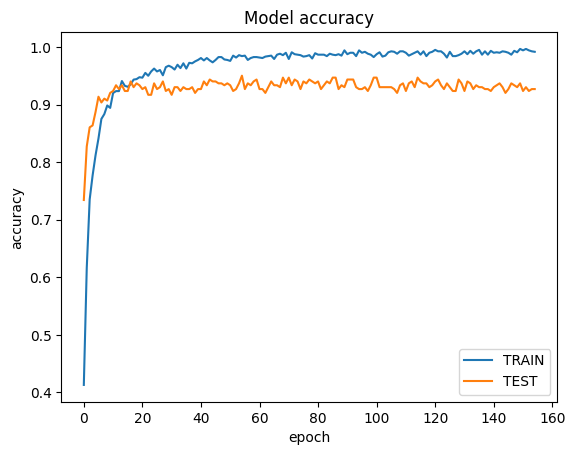

In [ ]:
# Visualize the training history to see whether you're overfitting.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['TRAIN', 'VAL'], loc='lower right')
plt.show()

In [ ]:
from keras.models import load_model

model = load_model("/content/drive/MyDrive/UGP23/dataset/Yoga_82_modified/weights_yoga82_norm.best_ann.hdf5")

In [ ]:
model.evaluate(x_train, y_train)

38/38 [==============================] - 0s 1ms/step - loss: 0.0107 - accuracy: 0.9983


[0.010724058374762535, 0.9983347058296204]

In [ ]:
model.evaluate(x_val, y_val)

10/10 [==============================] - 0s 2ms/step - loss: 0.2572 - accuracy: 0.9502


[0.2572401165962219, 0.9501661062240601]

In [ ]:
model.evaluate(x_test, y_test)

12/12 [==============================] - 0s 1ms/step - loss: 0.2481 - accuracy: 0.9415


[0.24813294410705566, 0.9414893388748169]

In [ ]:
y_pred = model.predict(x_test)

12/12 [==============================] - 0s 1ms/step


In [ ]:
y_pred

array([[9.5096202e-06, 5.2247224e-09, 7.0916789e-10, ..., 2.5627671e-06,
        1.0456408e-08, 7.1706535e-07],
       [9.9998790e-01, 3.0128278e-09, 3.6043438e-12, ..., 1.4966886e-07,
        8.4043563e-13, 9.4151096e-09],
       [4.1503379e-09, 7.5836155e-09, 3.0135592e-08, ..., 9.9999744e-01,
        5.1562231e-12, 1.9623860e-08],
       ...,
       [4.3713522e-12, 2.9585218e-08, 9.9999613e-01, ..., 3.8835833e-07,
        1.9355637e-07, 6.9294122e-09],
       [9.3177348e-11, 9.9999541e-01, 2.1180915e-07, ..., 1.5304332e-09,
        4.3811949e-10, 3.7240561e-10],
       [2.2485569e-06, 2.9616657e-04, 2.0364725e-03, ..., 1.3070168e-01,
        1.0129886e-05, 1.0519581e-05]], dtype=float32)

In [ ]:
y_pred.shape

(376, 9)

In [ ]:
y_pred[0]

array([9.50962021e-06, 5.22472243e-09, 7.09167891e-10, 1.13961654e-07,
       9.99986708e-01, 2.40145141e-07, 2.56276712e-06, 1.04564082e-08,
       7.17065348e-07], dtype=float32)

In [ ]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([4, 0, 6, 0, 5, 4, 3, 8, 6, 3, 0, 6, 1, 3, 8, 0, 3, 3, 5, 6, 7, 6,
       2, 0, 6, 6, 4, 6, 3, 6, 5, 7, 6, 8, 4, 4, 3, 0, 6, 4, 6, 6, 4, 6,
       4, 0, 4, 2, 4, 2, 8, 2, 8, 6, 0, 3, 7, 7, 6, 4, 7, 8, 4, 4, 6, 3,
       5, 3, 5, 5, 7, 2, 6, 4, 3, 3, 3, 8, 2, 7, 8, 7, 2, 1, 8, 3, 7, 7,
       5, 6, 7, 5, 8, 4, 1, 7, 6, 5, 0, 5, 6, 4, 5, 0, 0, 4, 0, 8, 1, 6,
       6, 4, 5, 6, 4, 1, 8, 6, 5, 8, 2, 3, 2, 3, 6, 6, 7, 6, 1, 4, 4, 6,
       7, 1, 8, 8, 4, 2, 6, 7, 5, 6, 0, 8, 2, 2, 3, 0, 5, 5, 4, 5, 5, 8,
       8, 4, 8, 8, 6, 0, 0, 1, 2, 7, 0, 1, 8, 5, 7, 6, 0, 7, 8, 6, 4, 4,
       4, 7, 2, 6, 8, 2, 4, 5, 8, 4, 6, 0, 5, 4, 7, 6, 4, 5, 2, 8, 8, 6,
       6, 6, 3, 7, 7, 4, 3, 6, 8, 2, 6, 4, 0, 6, 2, 2, 8, 8, 8, 7, 0, 4,
       0, 8, 6, 6, 1, 6, 5, 5, 1, 4, 4, 4, 6, 0, 5, 5, 5, 2, 3, 6, 2, 8,
       8, 2, 8, 1, 2, 6, 3, 3, 2, 7, 6, 8, 3, 7, 8, 1, 7, 3, 0, 8, 2, 4,
       1, 6, 3, 4, 4, 8, 8, 5, 7, 0, 7, 6, 6, 8, 3, 7, 2, 4, 4, 7, 8, 6,
       4, 8, 1, 6, 6, 5, 2, 1, 6, 6, 3, 6, 1, 1, 0,

In [ ]:
pose_test = [None] * y_test.size
pose_pred = [None] * y_pred.size

for i in range(len(y_test)):
    if(y_test[i]==0): pose_test[i] = 'Plank'           
    if(y_test[i]==1): pose_test[i] = 'Warrior_I'       
    if(y_test[i]==2): pose_test[i] = 'Standing_big_toe'     
    if(y_test[i]==3): pose_test[i] = 'Warrior_II'         
    if(y_test[i]==4): pose_test[i] = 'Cat_Cow'         
    if(y_test[i]==5): pose_test[i] = 'Child'            
    if(y_test[i]==6): pose_test[i] = 'Cobra'     
    if(y_test[i]==7): pose_test[i] = 'Tree'              
    if(y_test[i]==8): pose_test[i] = 'Downward-Facing_Dog'


for i in range(len(y_pred)):
    if(y_pred[i]==0): pose_pred[i] = 'Plank'                           
    if(y_pred[i]==1): pose_pred[i] = 'Warrior_I'                   
    if(y_pred[i]==2): pose_pred[i] = 'Standing_big_toe'     
    if(y_pred[i]==3): pose_pred[i] = 'Warrior_II'                      
    if(y_pred[i]==4): pose_pred[i] = 'Cat_Cow'                                              
    if(y_pred[i]==5): pose_pred[i] = 'Child'                                 
    if(y_pred[i]==6): pose_pred[i] = 'Cobra'                              
    if(y_pred[i]==7): pose_pred[i] = 'Tree'                                    
    if(y_pred[i]==8): pose_pred[i] = 'Downward-Facing_Dog'     

In [ ]:
confusion_matrix(pose_test, pose_pred)

array([[54,  1,  2,  3,  0,  0,  0,  0,  0],
       [ 2, 36,  0,  0,  1,  1,  0,  0,  0],
       [ 1,  2, 65,  0,  0,  1,  0,  0,  0],
       [ 0,  1,  0, 45,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0, 28,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0, 30,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 33,  0,  1],
       [ 0,  1,  0,  0,  0,  0,  0, 26,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  1, 37]])

In [ ]:
! pip install -q scikit-plot

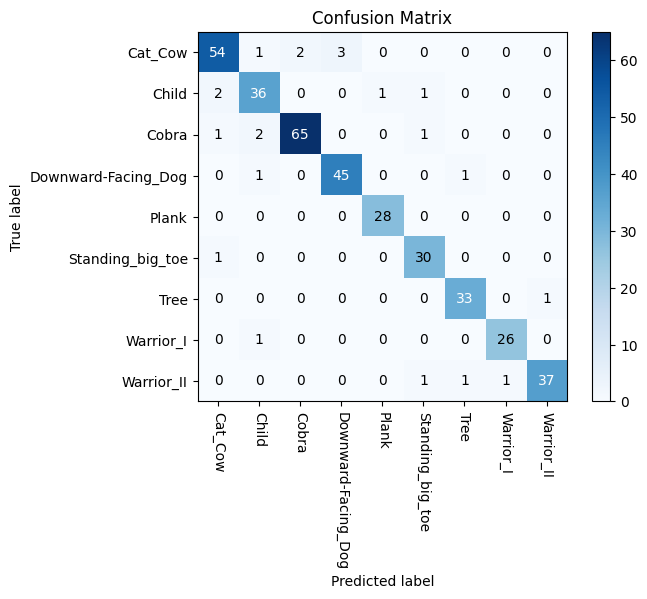

In [ ]:
import matplotlib.pyplot as plt
import scikitplot as skplt

skplt.metrics.plot_confusion_matrix(pose_test, pose_pred)

# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=270)
plt.show()

In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score

f1_score(pose_test, pose_pred, average='weighted')

0.9414753642133932

In [ ]:
precision_score(pose_test, pose_pred, average='weighted')

0.9420415715721447

In [ ]:
recall_score(pose_test, pose_pred, average='weighted')

0.9414893617021277

In [ ]:
from sklearn.metrics import f1_score

# Convert pose_val and pose_pred to numpy arrays
nppose_val = np.array(pose_test)
nppose_pred = np.array(pose_pred)

# Get a list of all unique labels
labels = np.unique(nppose_val)

# Calculate F1 score for each label
for label in labels:
    # Create a binary array indicating if the label matches the current label
    y_true = (nppose_val == label)
    y_pred = (nppose_pred == label)
    
    # Calculate F1 score
    f1 = f1_score(y_true, y_pred)
    
    # Print the F1 score for the current label
    print(f"F1 score for {label}: {f1}")


F1 score for Cat_Cow: 0.9152542372881356
F1 score for Child: 0.888888888888889
F1 score for Cobra: 0.9558823529411764
F1 score for Downward-Facing_Dog: 0.9473684210526315
F1 score for Plank: 0.9824561403508771
F1 score for Standing_big_toe: 0.9374999999999999
F1 score for Tree: 0.9565217391304348
F1 score for Warrior_I: 0.9629629629629629
F1 score for Warrior_II: 0.9487179487179489
